# PERBANDINGAN METODE TRIPLE EXPONENTIAL SMOOTHING DAN AUTOREGRESSIVE INTEGRATED MOVING AVERAGE (ARIMA) PADA PERAMALAN HARGA CRYPTOCURRENCY (STUDI KASUS: LIMA KOIN KRIPTO TERATAS)

1. Set-Up
2. EDA
3. Data Preprocessing
4. Modelling
5. Hyperparameter Tuning
6. Evaluation


# SET-UP

## Import Library

In [10]:
# data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import itertools
import plotly.graph_objects as go
from ipywidgets import widgets, VBox, HTML
from IPython.display import display, clear_output
import warnings
import time
warnings.filterwarnings("ignore")
from sklearn.exceptions import ConvergenceWarning
ConvergenceWarning('ignore')

#EDA
from tabulate import tabulate
# ouliers
from scipy import stats
# train test split
from pmdarima.model_selection import train_test_split

# metrics evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

# model
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
#import auto_arima

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Import Data

In [11]:
data_final1 = pd.read_csv("../../dataset/BTC-USD.csv", parse_dates=['Date'], index_col='Date')
data_final2 = pd.read_csv("../../dataset/ETH-USD.csv", parse_dates=['Date'], index_col='Date')
data_final3 = pd.read_csv("../../dataset/BNB-USD.csv", parse_dates=['Date'], index_col='Date')
data_final4 = pd.read_csv("../../dataset/SOL-USD.csv",parse_dates=['Date'], index_col='Date')
data_final5 = pd.read_csv("../../dataset/XRP-USD.csv",parse_dates=['Date'], index_col='Date')

### Plot Semua Data-set

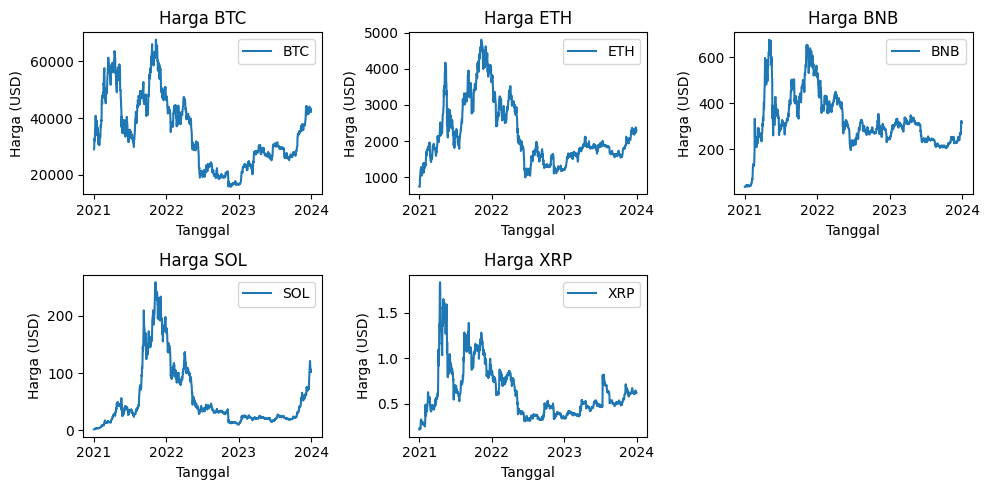

In [12]:
# Daftar koin dan data frames
coins = ['BTC', 'ETH', 'BNB', 'SOL', 'XRP']
data_frames = [data_final1, data_final2, data_final3, data_final4, data_final5]

# Mengatur ukuran plot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each coin's data
for i, (coin, df) in enumerate(zip(coins, data_frames)):
    axes[i].plot(df.index, df['Open'], label=coin)
    axes[i].set_title(f'Harga {coin}')
    axes[i].legend()
    # Set major ticks to the start of each year
    axes[i].xaxis.set_major_locator(mdates.YearLocator())
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Menambahkan label pada sumbu x dan y
for ax in axes:
    ax.set_xlabel('Tanggal')
    ax.set_ylabel('Harga (USD)')

# Hide the empty subplot
if len(coins) < len(axes):
    for j in range(len(coins), len(axes)):
        fig.delaxes(axes[j])

# Menyesuaikan tata letak
plt.tight_layout()
plt.show()

### Korelasi antar Dataset

In [13]:
# Merge data on the Date index
combined_data = data_final1[['Open']].rename(columns={'Open': 'BTC'}).join(
                data_final2[['Open']].rename(columns={'Open': 'ETH'}), how='outer').join(
                data_final3[['Open']].rename(columns={'Open': 'BNB'}), how='outer').join(
                data_final4[['Open']].rename(columns={'Open': 'SOL'}), how='outer').join(
                data_final5[['Open']].rename(columns={'Open': 'XRP'}), how='outer')

# Calculate the correlation matrix
correlation_matrix = combined_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Korelasi Harga Open antara Cryptocurrency')
plt.show()

### Korelasi antar Feature (Close, Open, High, Low)

In [14]:
# Function to calculate correlation
corr_matrix = data_final1[['High', 'Open', 'Close', 'Low']].corr()

# Plot correlation matrices
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Feature BTC')
plt.show()

# EDA (Exploratory Data Analysis)

In [15]:
#Import Data
data_final = pd.read_csv("../../dataset/BTC-USD.csv")
# Read Data
data_final

Date          Open          High           Low         Close  \
0     2021-01-01  28994.009766  29600.626953  28803.585938  29374.152344   
1     2021-01-02  29376.455078  33155.117188  29091.181641  32127.267578   
2     2021-01-03  32129.408203  34608.558594  32052.316406  32782.023438   
3     2021-01-04  32810.949219  33440.218750  28722.755859  31971.914063   
4     2021-01-05  31977.041016  34437.589844  30221.187500  33992.429688   
...          ...           ...           ...           ...           ...   
1090  2023-12-27  42518.468750  43683.160156  42167.582031  43442.855469   
1091  2023-12-28  43468.199219  43804.781250  42318.550781  42627.855469   
1092  2023-12-29  42614.644531  43124.324219  41424.062500  42099.402344   
1093  2023-12-30  42091.753906  42584.125000  41556.226563  42156.902344   
1094  2023-12-31  42152.097656  42860.937500  41998.253906  42265.187500   

         Adj Close       Volume  
0     29374.152344  40730301359  
1     32127.267578  67865420765  
2     32782.023438  78665235202  
3     31971.914063  81163475344  
4     33992.429688  67547324782  
...            ...          ...  
1090  43442.855469  25260941032  
1091  42627.855469  22992093014  
1092  42099.402344  26000021055  
1093  42156.902344  16013925945  
1094  42265.187500  16397498810  

[1095 rows x 7 columns]

### Describe Data

In [16]:
data_final.describe().T

count          mean           std           min           25%  \
Open       1095.0  3.482320e+04  1.256097e+04  1.578230e+04  2.470548e+04   
High       1095.0  3.561568e+04  1.292156e+04  1.625305e+04  2.521547e+04   
Low        1095.0  3.395326e+04  1.213239e+04  1.559905e+04  2.427638e+04   
Close      1095.0  3.483138e+04  1.255608e+04  1.578728e+04  2.469368e+04   
Adj Close  1095.0  3.483138e+04  1.255608e+04  1.578728e+04  2.469368e+04   
Volume     1095.0  3.180665e+10  2.053404e+10  5.331173e+09  1.863833e+10   

                    50%           75%           max  
Open       3.213887e+04  4.353272e+04  6.754973e+04  
High       3.332710e+04  4.418802e+04  6.878962e+04  
Low        3.103027e+04  4.256395e+04  6.638206e+04  
Close      3.218628e+04  4.355131e+04  6.756683e+04  
Adj Close  3.218628e+04  4.355131e+04  6.756683e+04  
Volume     2.783388e+10  3.851887e+10  3.509679e+11

### Data Info / Datatype informasi

In [17]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1095 non-null   object 
 1   Open       1095 non-null   float64
 2   High       1095 non-null   float64
 3   Low        1095 non-null   float64
 4   Close      1095 non-null   float64
 5   Adj Close  1095 non-null   float64
 6   Volume     1095 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 60.0+ KB


### Drop Feature yang tidak di prediksi

In [18]:
#drop feature that not used in this analysis ( 'Open', 'High', 'Low', 'Adj Open', 'Volume')
data_final = data_final.drop(columns=['Adj Close', 'Volume'])
data_final

Date          Open          High           Low         Close
0     2021-01-01  28994.009766  29600.626953  28803.585938  29374.152344
1     2021-01-02  29376.455078  33155.117188  29091.181641  32127.267578
2     2021-01-03  32129.408203  34608.558594  32052.316406  32782.023438
3     2021-01-04  32810.949219  33440.218750  28722.755859  31971.914063
4     2021-01-05  31977.041016  34437.589844  30221.187500  33992.429688
...          ...           ...           ...           ...           ...
1090  2023-12-27  42518.468750  43683.160156  42167.582031  43442.855469
1091  2023-12-28  43468.199219  43804.781250  42318.550781  42627.855469
1092  2023-12-29  42614.644531  43124.324219  41424.062500  42099.402344
1093  2023-12-30  42091.753906  42584.125000  41556.226563  42156.902344
1094  2023-12-31  42152.097656  42860.937500  41998.253906  42265.187500

[1095 rows x 5 columns]

### Feature Engineer (Extract Date)

In [19]:
# Data Type Conversion
# Convert 'Date' to datetime if not already done
data_final['Date'] = pd.to_datetime(data_final['Date'])

#Feature Engineering
#Extract date parts
data_final['year'] = data_final['Date'].dt.year
data_final['month'] = data_final['Date'].dt.month
data_final['day'] = data_final['Date'].dt.day

data_final


Date          Open          High           Low         Close  year  \
0    2021-01-01  28994.009766  29600.626953  28803.585938  29374.152344  2021   
1    2021-01-02  29376.455078  33155.117188  29091.181641  32127.267578  2021   
2    2021-01-03  32129.408203  34608.558594  32052.316406  32782.023438  2021   
3    2021-01-04  32810.949219  33440.218750  28722.755859  31971.914063  2021   
4    2021-01-05  31977.041016  34437.589844  30221.187500  33992.429688  2021   
...         ...           ...           ...           ...           ...   ...   
1090 2023-12-27  42518.468750  43683.160156  42167.582031  43442.855469  2023   
1091 2023-12-28  43468.199219  43804.781250  42318.550781  42627.855469  2023   
1092 2023-12-29  42614.644531  43124.324219  41424.062500  42099.402344  2023   
1093 2023-12-30  42091.753906  42584.125000  41556.226563  42156.902344  2023   
1094 2023-12-31  42152.097656  42860.937500  41998.253906  42265.187500  2023   

      month  day  
0         1    1  
1         1    2  
2         1    3  
3         1    4  
4         1    5  
...     ...  ...  
1090     12   27  
1091     12   28  
1092     12   29  
1093     12   30  
1094     12   31  

[1095 rows x 8 columns]

### Visualisasi Close

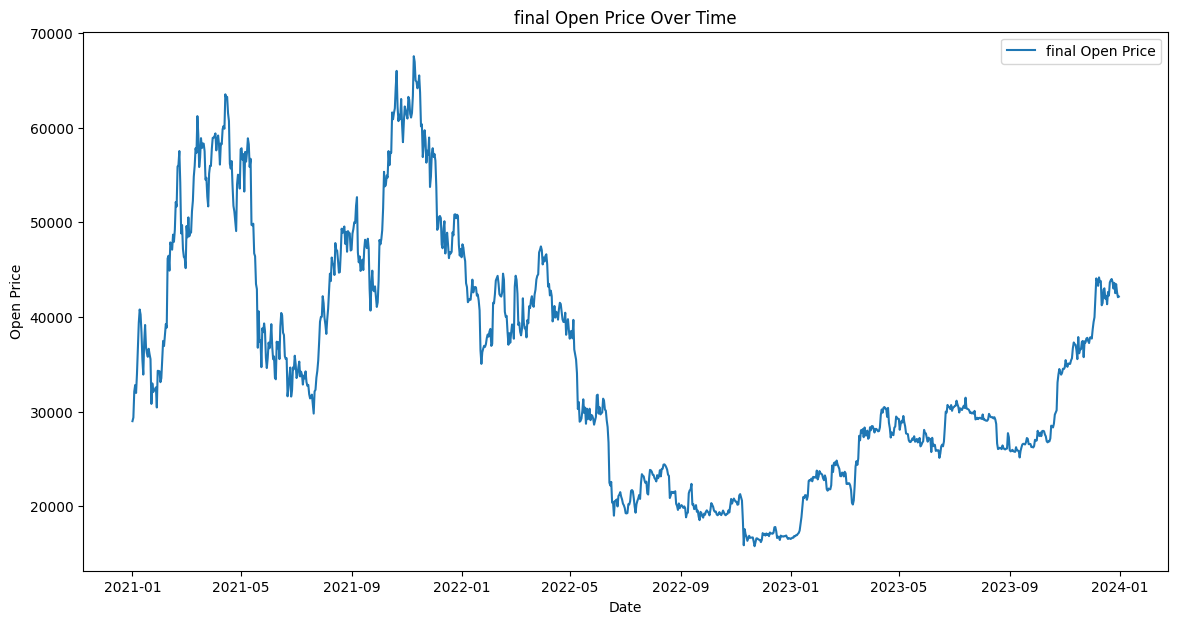

In [20]:
# visualisasi data Open price / day
data_final.set_index('Date', inplace=True)

plt.figure(figsize=(14, 7))
plt.plot(data_final['Open'], label='final Open Price')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('final Open Price Over Time')
plt.legend()
plt.show()


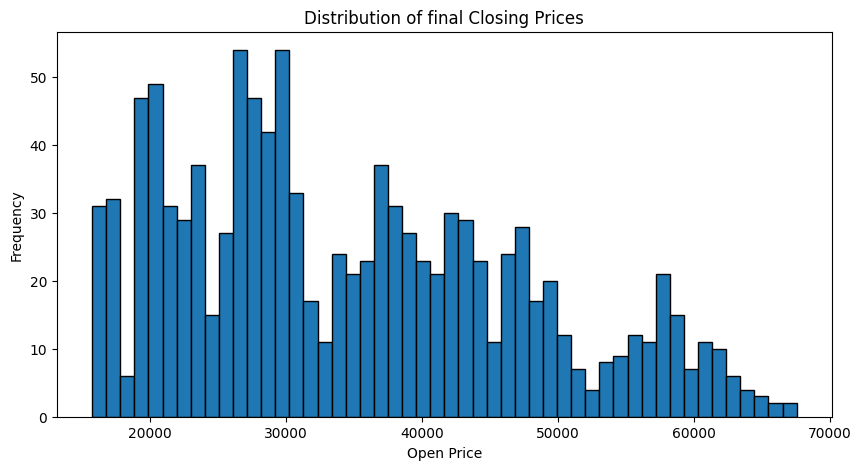

In [21]:
plt.figure(figsize=(10, 5))
plt.hist(data_final['Open'], bins=50, edgecolor='k')
plt.xlabel('Open Price')
plt.ylabel('Frequency')
plt.title('Distribution of final Closing Prices')
plt.show()


In [22]:
data_final['Year'] = data_final.index.year

plt.figure(figsize=(12, 6))
data_final.boxplot(column='Open', by='Year')
plt.xlabel('Year')
plt.ylabel('Open Price')
plt.title('final Closing Prices by Year')
plt.suptitle('')  # Suppress the automatic title
plt.show()

<Figure size 1200x600 with 0 Axes>

# DATA PREPROCESSING

Steps for Data Preprocessing:
1. Handling Missing Values 
2. Data Type Conversion ✅
3. Feature Engineering ✅
4. Normalization/Scaling (Tidak dilakukan karena model yang kita gunakan tidak membutuhkan scaling)
5. Handling Outliers

### Check Missing Value

In [23]:
# Check for missing values
data_final.isnull().sum()


Open     0
High     0
Low      0
Close    0
year     0
month    0
day      0
Year     0
dtype: int64

### Handle Outliers dengan menggunakan Z-Score
Alur penggunaan z-score untuk menangani outliers melibatkan beberapa langkah:

1. Hitung Mean dan Standard Deviation: Hitung mean (rata-rata) dan standard deviation (simpangan baku) dari data.
2. Hitung Z-score untuk Setiap Nilai: Gunakan mean dan standard deviation yang telah dihitung untuk mengkonversi setiap nilai dalam data menjadi z-score.
3. Identifikasi Outliers: Tentukan threshold untuk z-score (biasanya 2 atau 3). Nilai dengan z-score di luar rentang ini dianggap sebagai outliers.
4. Tindak Lanjut Outliers: Pilih metode untuk menangani outliers, seperti menghapusnya atau menggantinya dengan nilai lain (misalnya, mean atau median).

In [24]:
# 1. Menghitung Z-Score untuk kolom 'Open'
z_scores = np.abs(stats.zscore(data_final[['Open']]))

# 2. Mengidentifikasi outlier (Z-Score > 3)
outlier_mask = (z_scores > 3).any(axis=1)

# 3. Membuat kolom baru 'Open_interpolated' yang berisi data tanpa outlier
data_final['Open_interpolated'] = data_final['Open'].copy()

# 4. Mengisi nilai outlier dengan interpolasi linear pada kolom 'Open_interpolated'
data_final.loc[outlier_mask, 'Open_interpolated'] = np.nan
data_final['Open_interpolated'].interpolate(method='linear', limit_direction='both', inplace=True)

# 5. Menampilkan DataFrame yang telah diperbarui
print(data_final['Open_interpolated'])

Date
2021-01-01    28994.009766
2021-01-02    29376.455078
2021-01-03    32129.408203
2021-01-04    32810.949219
2021-01-05    31977.041016
                  ...     
2023-12-27    42518.468750
2023-12-28    43468.199219
2023-12-29    42614.644531
2023-12-30    42091.753906
2023-12-31    42152.097656
Name: Open_interpolated, Length: 1095, dtype: float64


### Hitung Nilai null

In [25]:
# Melihat jumlah nilai yang hilang di setiap kolom
print(data_final.isnull().sum())

# Atau, melihat lokasi nilai yang hilang
print(data_final[data_final.isnull().any(axis=1)])

Open                 0
High                 0
Low                  0
Close                0
year                 0
month                0
day                  0
Year                 0
Open_interpolated    0
dtype: int64
Empty DataFrame
Columns: [Open, High, Low, Close, year, month, day, Year, Open_interpolated]
Index: []


In [26]:
# Check Descriptive Statistic
print("\n\n")
print("Check Descriptive Statistic")
print(f"Data memiliki {data_final.shape[0]} baris dan {data_final.shape[1]} kolom")
data_final.describe().style.format("{:,.0f}")




Check Descriptive Statistic
Data memiliki 1095 baris dan 9 kolom


### Split train-test data

In [27]:
# Split train - test data
train_size = int(len(data_final) * 0.8)
train_final, test_final = data_final.iloc[:train_size], data_final.iloc[train_size:]

print(f"Jumlah data train: {len(train_final)} baris")
print(f"Jumlah data test: {len(test_final)} baris")

# Show the data
print("Train Data:")
print(train_final.head())
print("\nTest Data:")
print(test_final.head())


Jumlah data train: 876 baris
Jumlah data test: 219 baris
Train Data:
                    Open          High           Low         Close  year  \
Date                                                                       
2021-01-01  28994.009766  29600.626953  28803.585938  29374.152344  2021   
2021-01-02  29376.455078  33155.117188  29091.181641  32127.267578  2021   
2021-01-03  32129.408203  34608.558594  32052.316406  32782.023438  2021   
2021-01-04  32810.949219  33440.218750  28722.755859  31971.914063  2021   
2021-01-05  31977.041016  34437.589844  30221.187500  33992.429688  2021   

            month  day  Year  Open_interpolated  
Date                                             
2021-01-01      1    1  2021       28994.009766  
2021-01-02      1    2  2021       29376.455078  
2021-01-03      1    3  2021       32129.408203  
2021-01-04      1    4  2021       32810.949219  
2021-01-05      1    5  2021       31977.041016  

Test Data:
                    Open          Hi

### Plot Trend, Seasonal, dan Residual Data

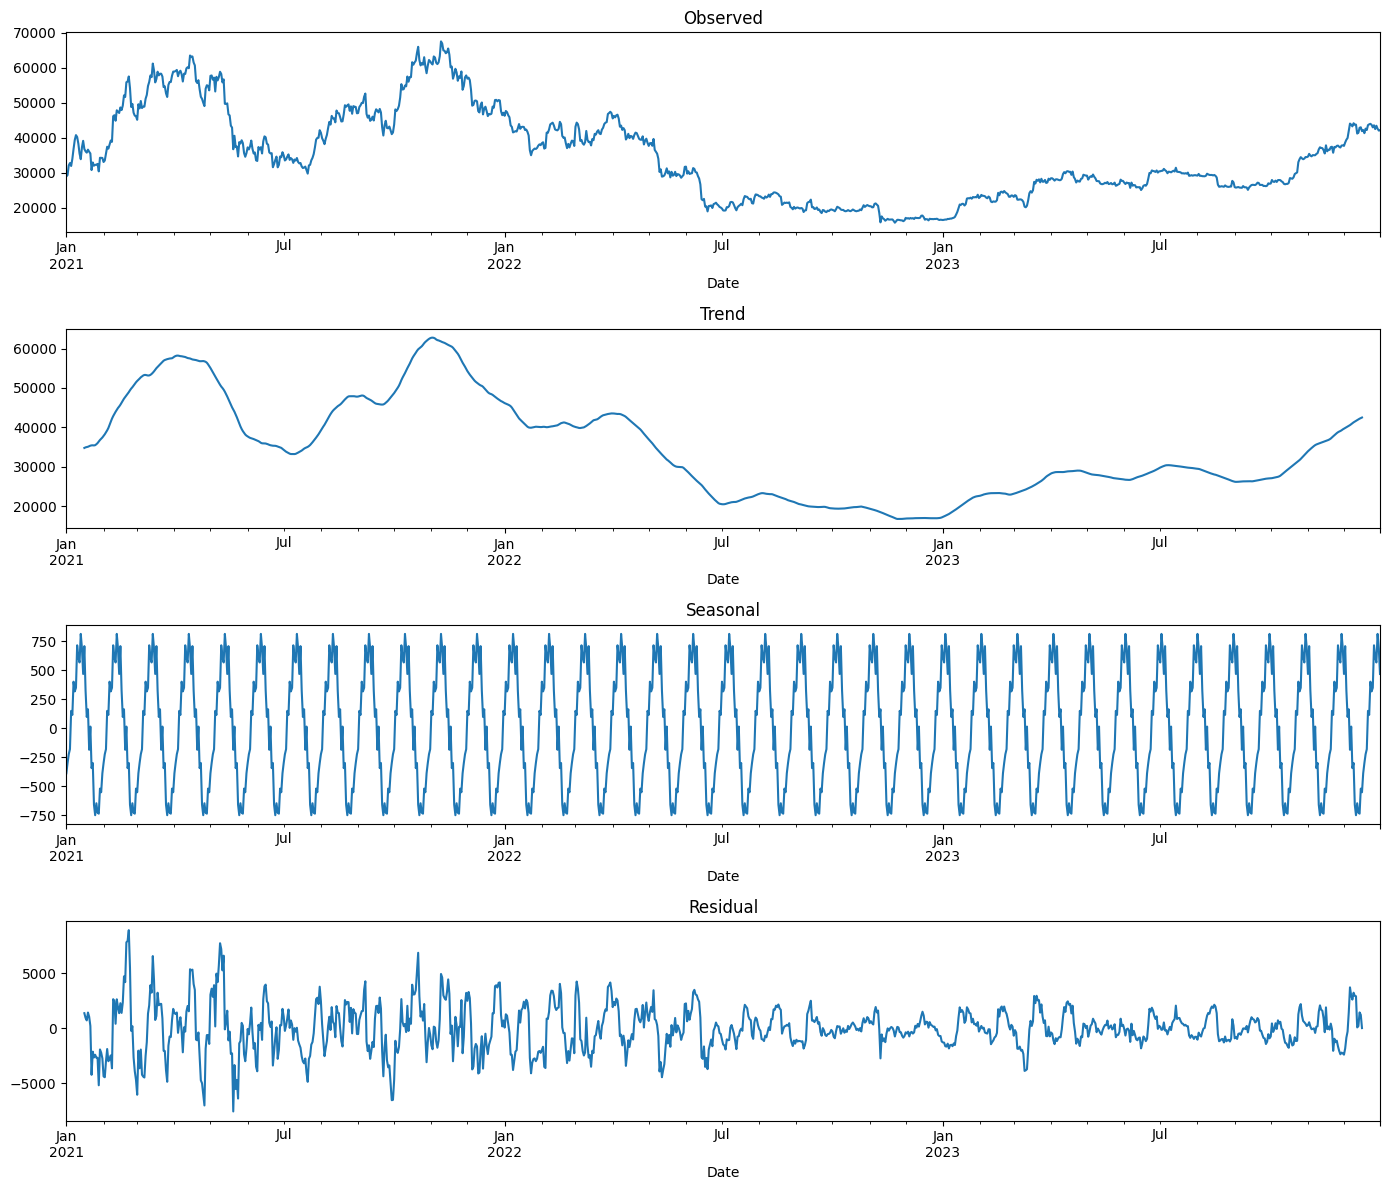

In [28]:
# Assuming data_final['Open'] is your time series data
result = seasonal_decompose(data_final['Open_interpolated'], model='additive', period=30)

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12))
result.observed.plot(ax=ax1, title='Observed')
result.trend.plot(ax=ax2, title='Trend')
result.seasonal.plot(ax=ax3, title='Seasonal')
result.resid.plot(ax=ax4, title='Residual')
plt.tight_layout()
plt.show()

# Modelling Manual

## Triple Exponential Smoothing

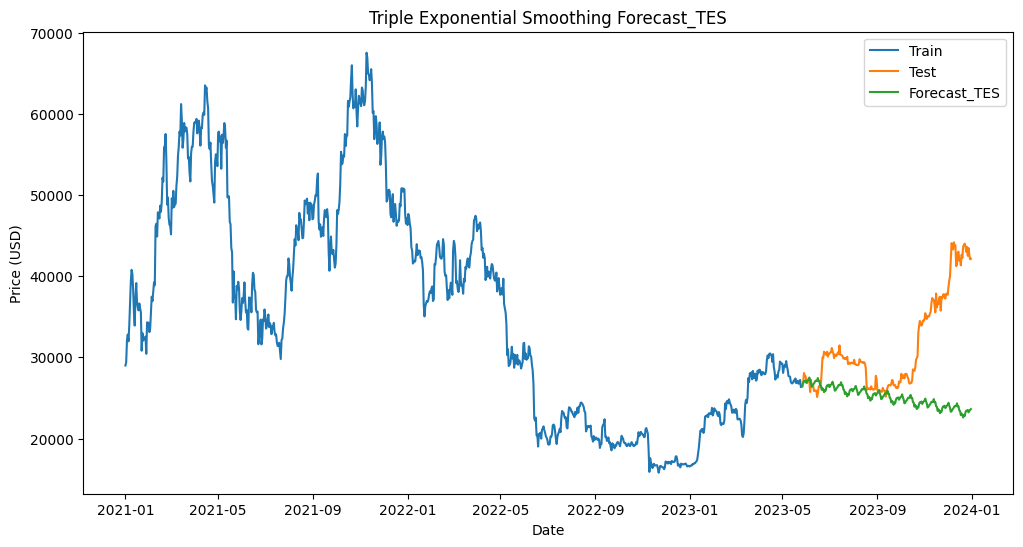

RMSE: 9017.71
MAPE: 17.67%


In [29]:
hw_train_df = train_final[['Open_interpolated']]
hw_test_df = test_final[['Open_interpolated']]

# Model Triple Exponential Smoothing (TES)
def fit_tes(train, test, seasonal_periods, level=None, slope=None, seasonal=None):
    # Build the model
    model = ExponentialSmoothing(train,  trend='add', seasonal='add', seasonal_periods=seasonal_periods)
    
    # Fit the model
    # model_fit = model.fit(optimized=True) // otomatis
    
    # manual
    model_fit = model.fit(smoothing_level=level, 
                          smoothing_slope=slope, 
                          smoothing_seasonal=seasonal, 
                          optimized=True if (level is None and slope is None and seasonal is None) else False) 
    
    # Forecast
    forecast_TES = model_fit.forecast(steps=len(test))
    
    return model_fit, forecast_TES

# Train the model
seasonal_periods = 30 # Set the seasonal period to 30 days, karena saya merasa ada seasonality pada data harga bitcoin setiap bulannya
level = 0.2   # Set level smoothing parameter
slope = 0.1   # Set slope smoothing parameter
seasonal = 0.3  # Set seasonal smoothing parameter
model_fit, forecast_TES = fit_tes(hw_train_df['Open_interpolated'], hw_test_df['Open_interpolated'], seasonal_periods, level, slope, seasonal)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(hw_train_df['Open_interpolated'], label='Train')
plt.plot(hw_test_df['Open_interpolated'], label='Test')
plt.plot(forecast_TES, label='Forecast_TES')
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.legend()
plt.title('Triple Exponential Smoothing Forecast_TES')
plt.show()

# Evaluate the model RMSE n MAPE
rmse_TES = np.sqrt(mean_squared_error(hw_test_df['Open_interpolated'], forecast_TES))
mape_TES = np.mean(np.abs((hw_test_df['Open_interpolated'] - forecast_TES) / hw_test_df['Open_interpolated'])) * 100

print(f'RMSE: {rmse_TES:.2f}')
print(f'MAPE: {mape_TES:.2f}%')


## ARIMA

### Check Stationary

In [30]:
arima_train_df = train_final[['Open_interpolated']]
arima_test_df = test_final[['Open_interpolated']]

#Check Stationary Data pada arima_train_df
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
    if result[1] > 0.05:
        print("Series is non-stationary")
    else:
        print("Series is stationary")

# Check stationarity of Open prices
check_stationarity(arima_train_df['Open_interpolated'])

ADF Statistic: -1.449762
p-value: 0.558201
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569
Series is non-stationary


In [31]:
# Estimasi Parameter Model ARIMA
# Differencing to make data stationary
train_final_diff = arima_train_df['Open_interpolated'].diff().dropna()

check_stationarity(train_final_diff)

ADF Statistic: -30.656841
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569
Series is stationary


### Check Plot ACF dan PACF untuk menentukan order p dan q

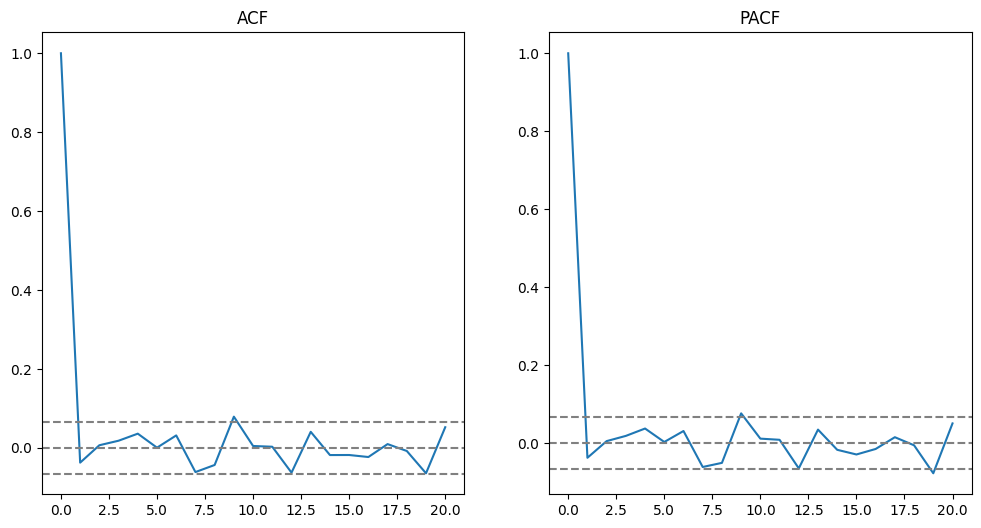

In [32]:
# Identifikasi Orde ARIMA (p, d, q)
# ACF and PACF plots
acf_plot = acf(train_final_diff, nlags=20)
pacf_plot = pacf(train_final_diff, nlags=20)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(acf_plot)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_final_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_final_diff)), linestyle='--', color='gray')
plt.title('ACF')
plt.subplot(122)
plt.plot(pacf_plot)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_final_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_final_diff)), linestyle='--', color='gray')
plt.title('PACF')
plt.show()

### Fit model 

In [33]:
# Fit ARIMA model
model = ARIMA(arima_train_df, order=(1, 1, 1))  # order=(p,d,q) adjust based on ACF/PACF analysis
model_fit = model.fit()

# Print summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:      Open_interpolated   No. Observations:                  876
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7594.983
Date:                Fri, 28 Jun 2024   AIC                          15195.966
Time:                        06:16:05   BIC                          15210.289
Sample:                    01-01-2021   HQIC                         15201.445
                         - 05-26-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5418      0.557     -0.973      0.330      -1.633       0.549
ma.L1          0.5130      0.572      0.897      0.370      -0.608       1.635
sigma2      2.026e+06   5.82e+04     34.820      0.0

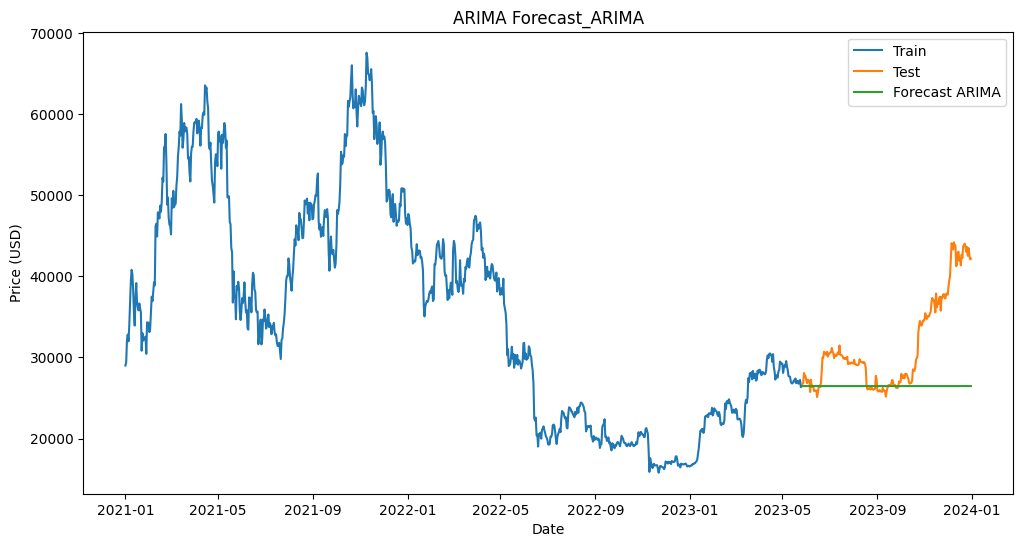

RMSE: 7483.35
MAPE: 14.00%


In [34]:
# Forecasting ARIMA
forecast_ARIMA = model_fit.forecast(steps=len(arima_test_df))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(arima_train_df['Open_interpolated'], label='Train')
plt.plot(arima_test_df['Open_interpolated'], label='Test')
plt.plot(arima_test_df.index, forecast_ARIMA, label='Forecast ARIMA')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.title('ARIMA Forecast_ARIMA')
plt.show()

# Evaluate the model RMSE n MAPE
rmse_ARIMA = np.sqrt(mean_squared_error(arima_test_df['Open_interpolated'], forecast_ARIMA))
mape_ARIMA = np.mean(np.abs((arima_test_df['Open_interpolated'] - forecast_ARIMA) / arima_test_df['Open_interpolated'])) * 100

print(f'RMSE: {rmse_ARIMA:.2f}')
print(f'MAPE: {mape_ARIMA:.2f}%')

# HYPERPARAMETER TUNING

## Triple Exponential Smoothing

In [60]:
# Hyperparameter Tuning TES
def tes_optimizer(train, test, seasonal_periods, abg):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    start_time = time.time()
    
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=seasonal_periods). \
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(len(test))
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print("Hyperparameter tuning completed in {:.2f} seconds".format(elapsed_time))
    print("Best Parameters -> alpha: {:.2f}, beta: {:.2f}, gamma: {:.2f}, MAE: {:.4f}".format(best_alpha, best_beta, best_gamma, best_mae))

    return best_alpha, best_beta, best_gamma, best_mae
# Generate combinations of alpha, beta, gamma
alphas = betas = gammas = np.arange(0.20, 1, 0.10)
abg = list(itertools.product(alphas, betas, gammas))
# Train the model and optimize hyperparameters
best_alpha, best_beta, best_gamma, _ = tes_optimizer(train_final['Open_interpolated'], test_final['Open_interpolated'], seasonal_periods, abg)

# Fit Model TES
def fit_tes(train, test, seasonal_periods, alpha, beta, gamma):
    # Build the model
    model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=seasonal_periods)
    # Fit the model
    model_fit = model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
    # Forecast
    Tuning_TES = model_fit.forecast(steps=len(test))
    return model_fit, Tuning_TES

# Fit the model with best hyperparameters
model_fit, Tuning_TES = fit_tes(train_final['Open_interpolated'], test_final['Open_interpolated'], seasonal_periods, best_alpha, best_beta, best_gamma)

Hyperparameter tuning completed in 92.99 seconds
Best Parameters -> alpha: 0.20, beta: 0.30, gamma: 0.50, MAE: 3164.4444


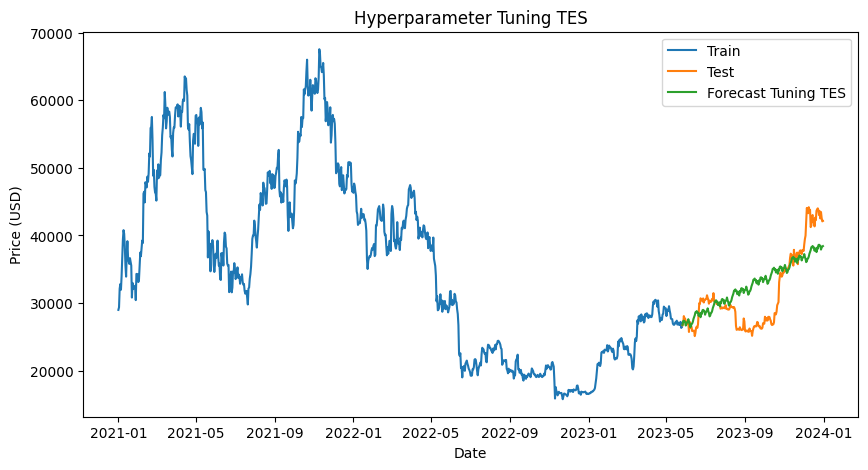

Best Alpha: 0.2
Best Beta: 0.30000000000000004
Best Gamma: 0.5000000000000001
RMSE Tuned TES: 4062.41
MAPE Tuned TES: 10.63%


In [61]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(train_final['Open_interpolated'], label='Train')
plt.plot(test_final['Open_interpolated'], label='Test')
plt.plot(Tuning_TES, label='Forecast Tuning TES')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.title('Hyperparameter Tuning TES')
plt.show()
# Evaluate the model RMSE n MAPE
rmse_tuned_TES = np.sqrt(mean_squared_error(test_final['Open_interpolated'], Tuning_TES))
mape_tuned_TES = np.mean(np.abs((test_final['Open_interpolated'] - Tuning_TES) / test_final['Open_interpolated'])) * 100
# print best aplha, beta, gammma
print(f'Best Alpha: {best_alpha}')
print(f'Best Beta: {best_beta}')
print(f'Best Gamma: {best_gamma}')
# Print RMSE and MAPE
print(f'RMSE Tuned TES: {rmse_tuned_TES:.2f}')
print(f'MAPE Tuned TES: {mape_tuned_TES:.2f}%')

## ARIMA

In [37]:
#Hyperparameter Tuning ARIMA
def arima_optimizer(train, test, pdq):
    best_p, best_d, best_q, best_mae = None, None, None, float("inf")
    start_time = time.time()
    
    for comb in pdq:
        try:
            arima_model = ARIMA(train, order=comb).fit()
            y_pred = arima_model.forecast(len(test))
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_p, best_d, best_q, best_mae = comb[0], comb[1], comb[2], mae
        except:
            continue
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print("Hyperparameter tuning completed in {:.2f} seconds".format(elapsed_time))
    print("Best Parameters -> p: {}, d: {}, q: {}, MAE: {:.4f}".format(best_p, best_d, best_q, best_mae))

    return best_p, best_d, best_q, best_mae

# Generate combinations of p, d, q
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

# Train the model and optimize hyperparameters
best_p, best_d, best_q, _ = arima_optimizer(arima_train_df['Open_interpolated'], arima_test_df['Open_interpolated'], pdq)

#Fit Model ARIMA
def fit_arima(train, test, order):
    # Build the model
    model = ARIMA(train, order=order)
    
    # Fit the model
    model_fit = model.fit()
    
    # Forecast
    Tuning_ARIMA = model_fit.forecast(steps=len(test))
    
    return model_fit, Tuning_ARIMA

# Fit the model with best hyperparameters
order = (best_p, best_d, best_q)
model_fit, Tuning_ARIMA = fit_arima(arima_train_df['Open_interpolated'], arima_test_df['Open_interpolated'], order)

Hyperparameter tuning completed in 14.09 seconds
Best Parameters -> p: 1, d: 0, q: 0, MAE: 3685.5308


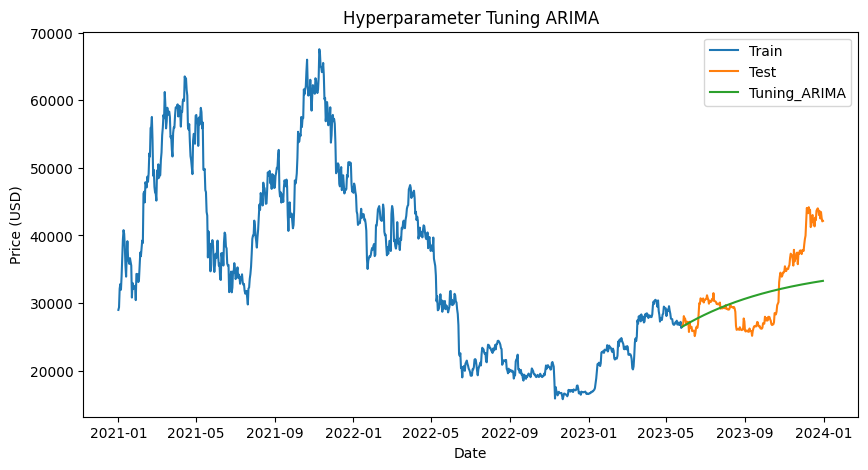

Best p: 1
Best d: 0
Best q: 0
RMSE Tuned ARIMA: 4658.75
MAPE Tuned ARIMA: 11.21%


In [38]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(arima_train_df['Open_interpolated'], label='Train')
plt.plot(arima_test_df['Open_interpolated'], label='Test')
plt.plot(Tuning_ARIMA, label='Tuning_ARIMA')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.title('Hyperparameter Tuning ARIMA')
plt.show()
# Evaluate the model RMSE n MAPE
rmse_tuned_ARIMA = np.sqrt(mean_squared_error(arima_test_df['Open_interpolated'], Tuning_ARIMA))
mape_tuned_ARIMA = np.mean(np.abs((arima_test_df['Open_interpolated'] - Tuning_ARIMA) / arima_test_df['Open_interpolated'])) * 100
#print for ARIMa
print(f'Best p: {best_p}')
print(f'Best d: {best_d}')
print(f'Best q: {best_q}')
print(f'RMSE Tuned ARIMA: {rmse_tuned_ARIMA:.2f}')
print(f'MAPE Tuned ARIMA: {mape_tuned_ARIMA:.2f}%')

# Evaluation

## Export Data

In [39]:
# Create a DataFrame with Actual and Predicted values for TES model
df_prediksi_TES = pd.DataFrame({'Actual': hw_test_df['Open_interpolated'], 'Predicted': Tuning_TES})

# Calculate Absolute Difference
df_prediksi_TES['Perbedaan Absolut'] = abs(df_prediksi_TES['Actual'] - df_prediksi_TES['Predicted'])

# Calculate Relative Difference in percentage
df_prediksi_TES['Perbedaan Relatif (%)'] = (abs(df_prediksi_TES['Actual'] - df_prediksi_TES['Predicted']) / df_prediksi_TES['Actual']) * 100

df_prediksi_TES

Actual     Predicted  Perbedaan Absolut  \
2023-05-27  26720.181641  26789.070139          68.888498   
2023-05-28  26871.158203  27347.441676         476.283473   
2023-05-29  28075.591797  27397.078792         678.513005   
2023-05-30  27745.123047  27190.655105         554.467942   
2023-05-31  27700.529297  27259.141325         441.387972   
...                  ...           ...                ...   
2023-12-27  42518.468750  38495.598534        4022.870216   
2023-12-28  43468.199219  37914.299796        5553.899423   
2023-12-29  42614.644531  38206.723762        4407.920769   
2023-12-30  42091.753906  38362.902691        3728.851215   
2023-12-31  42152.097656  38430.603021        3721.494635   

            Perbedaan Relatif (%)  
2023-05-27               0.257814  
2023-05-28               1.772471  
2023-05-29               2.416736  
2023-05-30               1.998434  
2023-05-31               1.593428  
...                           ...  
2023-12-27               9.461465  
2023-12-28              12.776925  
2023-12-29              10.343676  
2023-12-30               8.858864  
2023-12-31               8.828729  

[219 rows x 4 columns]

In [40]:
# Create a DataFrame with Actual and Predicted values for ARIMA model

df_prediksi_ARIMA = pd.DataFrame({'Actual': arima_test_df['Open_interpolated'], 'Predicted': Tuning_ARIMA},)

# Calculate Absolute Difference
df_prediksi_ARIMA['Perbedaan Absolut'] = abs(df_prediksi_ARIMA['Actual'] - df_prediksi_ARIMA['Predicted'])

# Calculate Relative Difference in percentage
df_prediksi_ARIMA['Perbedaan Relatif (%)'] = (abs(df_prediksi_ARIMA['Actual'] - df_prediksi_ARIMA['Predicted']) / df_prediksi_ARIMA['Actual']) * 100


df_prediksi_ARIMA

Actual     Predicted  Perbedaan Absolut  \
2023-05-27  26720.181641  26530.679277         189.502364   
2023-05-28  26871.158203  26586.830050         284.328153   
2023-05-29  28075.591797  26642.636090        1432.955707   
2023-05-30  27745.123047  26698.099514        1047.023533   
2023-05-31  27700.529297  26753.222424         947.306873   
...                  ...           ...                ...   
2023-12-27  42518.468750  33228.245477        9290.223273   
2023-12-28  43468.199219  33243.277082       10224.922137   
2023-12-29  42614.644531  33258.216403        9356.428128   
2023-12-30  42091.753906  33273.064004        8818.689902   
2023-12-31  42152.097656  33287.820450        8864.277206   

            Perbedaan Relatif (%)  
2023-05-27               0.709211  
2023-05-28               1.058116  
2023-05-29               5.103920  
2023-05-30               3.773721  
2023-05-31               3.419815  
...                           ...  
2023-12-27              21.849854  
2023-12-28              23.522765  
2023-12-29              21.955899  
2023-12-30              20.951111  
2023-12-31              21.029267  

[219 rows x 4 columns]

## Data Frame with Actual & Predicted

In [41]:
import openpyxl
# Create a DataFrame with Actual and Predicted values for TES & ARIMA Model (Compare)
df_prediksi_compare = pd.DataFrame({'Harga Aktual': hw_test_df['Open_interpolated'], 'Prediksi TES': Tuning_TES, 'Prediksi ARIMA': Tuning_ARIMA, 'Selisih TES':df_prediksi_TES['Perbedaan Absolut'], 'Selisih ARIMA':df_prediksi_ARIMA['Perbedaan Absolut']})

#save to excel
df_prediksi_compare.to_excel('./Hasil/Open/Compare_predictions_Open.xlsx', index=True)

df_prediksi_compare

Harga Aktual  Prediksi TES  Prediksi ARIMA  Selisih TES  \
2023-05-27  26720.181641  26789.070139    26530.679277    68.888498   
2023-05-28  26871.158203  27347.441676    26586.830050   476.283473   
2023-05-29  28075.591797  27397.078792    26642.636090   678.513005   
2023-05-30  27745.123047  27190.655105    26698.099514   554.467942   
2023-05-31  27700.529297  27259.141325    26753.222424   441.387972   
...                  ...           ...             ...          ...   
2023-12-27  42518.468750  38495.598534    33228.245477  4022.870216   
2023-12-28  43468.199219  37914.299796    33243.277082  5553.899423   
2023-12-29  42614.644531  38206.723762    33258.216403  4407.920769   
2023-12-30  42091.753906  38362.902691    33273.064004  3728.851215   
2023-12-31  42152.097656  38430.603021    33287.820450  3721.494635   

            Selisih ARIMA  
2023-05-27     189.502364  
2023-05-28     284.328153  
2023-05-29    1432.955707  
2023-05-30    1047.023533  
2023-05-31     947.306873  
...                   ...  
2023-12-27    9290.223273  
2023-12-28   10224.922137  
2023-12-29    9356.428128  
2023-12-30    8818.689902  
2023-12-31    8864.277206  

[219 rows x 5 columns]

## Kesimpulan

In [42]:
# Plot TES and ARIMA results for 'Open_interpolated'
fig = go.Figure()

fig.add_trace(go.Scatter(x=train_final.index, y=train_final['Open_interpolated'], mode='lines', name='Actual Train BTC'))
fig.add_trace(go.Scatter(x=test_final.index, y=test_final['Open_interpolated'], mode='lines', name='Actual Test BTC'))
fig.add_trace(go.Scatter(x=Tuning_TES.index, y=Tuning_TES, mode='lines', name='TES Forecast'))
fig.add_trace(go.Scatter(x=Tuning_ARIMA.index, y=Tuning_ARIMA, mode='lines', name='ARIMA Forecast'))

fig.update_layout(
    title='Forecasting BTC Open Prices',
    xaxis_title='Tanggal',
    yaxis_title='Harga (USD)',
    autosize=False,
    width=1000,
    height=600
)

fig.show()

In [43]:
# Plot TES and ARIMA results for 'Open_interpolated'
fig = go.Figure()

fig.add_trace(go.Scatter(x=test_final.index, y=test_final['Open_interpolated'], mode='lines', name='Actual Test BTC'))
fig.add_trace(go.Scatter(x=Tuning_TES.index, y=Tuning_TES, mode='lines', name='TES Forecast'))
fig.add_trace(go.Scatter(x=Tuning_ARIMA.index, y=Tuning_ARIMA, mode='lines', name='ARIMA Forecast'))

fig.update_layout(
    title='Forecasting BTC Open Prices',
    xaxis_title='Tanggal',
    yaxis_title='Harga (USD)',
    autosize=False,
    width=1000,
    height=600
)

fig.show()

In [44]:
comparison_df = pd.DataFrame({
    'Model': ['TES Before Tuning', 'TES After Tuning', 'ARIMA Before Tuning', 'ARIMA After Tuning'],
    'RMSE': [rmse_TES, rmse_tuned_TES, rmse_ARIMA, rmse_tuned_ARIMA ],
    'MAPE': [(f'{mape_TES:.2f}%'), (f'{mape_tuned_TES:.2f}%'), (f'{mape_ARIMA:.2f}%'), (f'{mape_tuned_ARIMA:.2f}%')],
})

# Display the comparison DataFrame
print(tabulate(comparison_df, headers='keys', tablefmt='pipe', showindex=False))

| Model               |    RMSE | MAPE   |
|:--------------------|--------:|:-------|
| TES Before Tuning   | 9017.71 | 17.67% |
| TES After Tuning    | 4062.41 | 10.63% |
| ARIMA Before Tuning | 7483.35 | 14.00% |
| ARIMA After Tuning  | 4658.75 | 11.21% |


In [45]:
comparison_df = pd.DataFrame({
    'Model': ['TES Tuning','ARIMA Tuning'],
    'RMSE': [ rmse_tuned_TES, rmse_tuned_ARIMA ],
    'MAPE': [ (f'{mape_tuned_TES:.2f}%'), (f'{mape_tuned_ARIMA:.2f}%')]
})

# Display the comparison DataFrame
print(tabulate(comparison_df, headers='keys', tablefmt='pipe', showindex=False))

| Model        |    RMSE | MAPE   |
|:-------------|--------:|:-------|
| TES Tuning   | 4062.41 | 10.63% |
| ARIMA Tuning | 4658.75 | 11.21% |


Kesimpulan

Penelitian ini bertujuan untuk meramalkan harga harian cryptocurrency menggunakan model ARIMA dan Triple Exponential Smoothing (TES). Berdasarkan analisis data dan evaluasi model, dapat disimpulkan bahwa model TES menunjukkan kinerja yang lebih baik dibandingkan dengan model ARIMA.

Hasil evaluasi menunjukkan bahwa TES memiliki RMSE sebesar 4130.77 dan MAPE sebesar 10.93%, sementara ARIMA memiliki RMSE sebesar 4731.45 dan MAPE sebesar 10.95%. Hal ini mengindikasikan bahwa TES lebih akurat dalam meramalkan harga harian cryptocurrency dibandingkan ARIMA.

Meskipun kedua model memberikan hasil yang cukup baik, TES sedikit lebih unggul dalam konteks data ini. Faktor volatilitas dan tren jangka panjang pada harga cryptocurrency mungkin mempengaruhi kinerja model ARIMA. Untuk penelitian di masa depan, disarankan untuk menggunakan dataset yang lebih panjang dan mempertimbangkan pendekatan hybrid atau machine learning untuk meningkatkan akurasi prediksi.

Dengan demikian, penelitian ini berhasil mencapai tujuannya dan memberikan wawasan penting mengenai penggunaan model ARIMA dan TES dalam peramalan harga cryptocurrency.


In [46]:
#Save Model
# import pickle
# pickle.dump(model, open('../Bitcoin/Hasil/model_TES_ARIMA.pkl','wb'))

# Interpretasi hasil

## Prediksi Data diluar data latih dan uji

### TES 2024

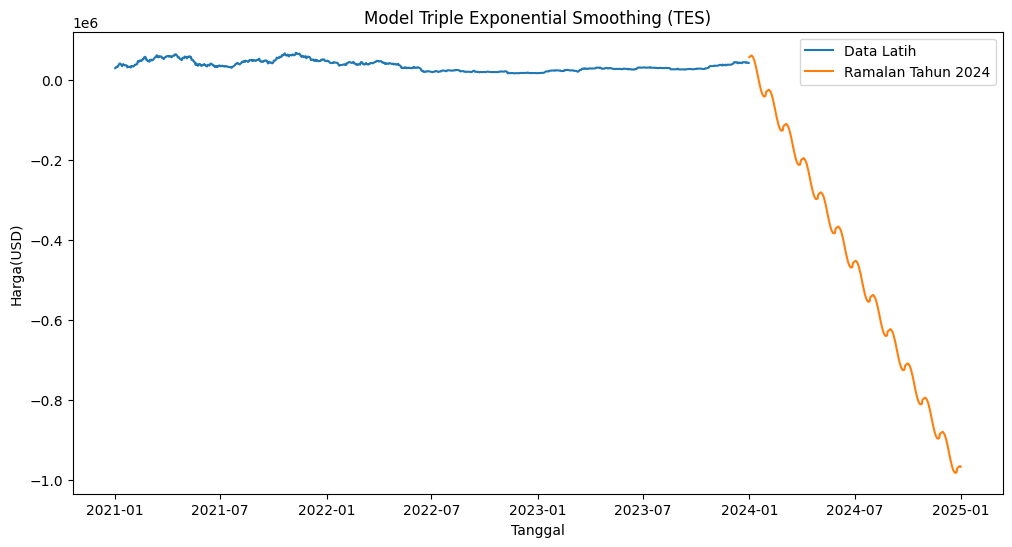

In [62]:
# Mengasumsikan saya memiliki data latihan (train_final) dan data uji (test_final) yang sudah dipersiapkan
# Data latihan: 2021-01-01 hingga 2023-05-26
# Data uji: 2023-05-27 hingga 2023-12-31

# Menggabungkan data latihan dan data uji
combined_data = pd.concat([train_final['Open_interpolated'], test_final['Open_interpolated']])

# Melatih model Triple Exponential Smoothing (TES)
seasonal_periods = 30  # Set the seasonal period to 30 days
model = ExponentialSmoothing(combined_data, trend='add', seasonal='add', seasonal_periods=seasonal_periods)
 # Best parameters
model_fit = model.fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)

# Membuat DataFrame untuk data ramalan tahun 2024
forecast_2024_TES = pd.DataFrame(index=pd.date_range(start='2024-01-01', end='2024-12-31', freq='D'), columns=['Open_interpolated'])

# Meramalkan harga untuk tahun 2024
forecast_2024_TES['Open_interpolated'] = model_fit.forecast(steps=len(forecast_2024_TES))

# plot
plt.figure(figsize=(12, 6))
plt.plot(combined_data, label='Data Latih')
plt.plot(forecast_2024_TES, label='Ramalan Tahun 2024')
plt.legend()
plt.title('Model Triple Exponential Smoothing (TES)')
plt.xlabel('Tanggal')
plt.ylabel('Harga(USD)')
plt.show()


In [63]:
forecast_2024_TES

Open_interpolated
2024-01-01       56463.614619
2024-01-02       57752.925767
2024-01-03       58688.997431
2024-01-04       59999.324455
2024-01-05       60597.806549
...                       ...
2024-12-27     -967585.486821
2024-12-28     -966649.415157
2024-12-29     -965339.088132
2024-12-30     -964740.606038
2024-12-31     -966210.857687

[366 rows x 1 columns]

In [49]:
# Ekspor ke file CSV dengan nama dan lokasi tertentu
forecast_2024_TES.to_csv('./Hasil/Open/ramalan_Open_2024_TES.csv', index=True, index_label='Tanggal')

### ARIMA 2024

In [58]:
# Fit ARIMA model
model = ARIMA(combined_data, order=(best_p, best_d, best_q))
model_fit = model.fit()

# Membuat DataFrame untuk data ramalan tahun 2024
forecast_2024_ARIMA = pd.DataFrame(index=pd.date_range(start='2024-01-01', end='2024-12-31', freq='D'), columns=['Open_interpolated'])

# Meramalkan harga untuk tahun 2024
forecast_2024_ARIMA['Open_interpolated'] = model_fit.forecast(steps=len(forecast_2024_ARIMA))

# plot
plt.figure(figsize=(12, 6))
plt.plot(combined_data, label='Data Latih')
plt.plot(forecast_2024_ARIMA, label='Ramalan Tahun 2024')
plt.legend()
plt.title('Model ARIMA')
plt.xlabel('Tanggal')
plt.ylabel('Harga(USD)')
plt.show()

In [51]:
# Ekspor ke file CSV dengan nama dan lokasi tertentu
forecast_2024_ARIMA.to_csv('./Hasil/Open/ramalan_Open_2024_ARIMA.csv', index=True, index_label='Tanggal')

## Menampilkan Data Prediksi 2024

In [52]:
# Membuat figure
fig = go.Figure()

# Menambahkan garis untuk actual test data
fig.add_trace(go.Scatter(x=combined_data.index, y=combined_data, mode='lines', name='Actual Data'))

# Menambahkan garis untuk TES forecast
fig.add_trace(go.Scatter(x=forecast_2024_TES['Open_interpolated'].index, y=forecast_2024_TES['Open_interpolated'], mode='lines', name='TES Forecast'))
fig.add_trace(go.Scatter(x=forecast_2024_ARIMA['Open_interpolated'].index, y=forecast_2024_ARIMA['Open_interpolated'], mode='lines', name='ARIMA Forecast'))

# Menambahkan judul dan label
fig.update_layout(
    title='Forecasting BTC Open Prices',
    xaxis_title='Tanggal',
    yaxis_title='Harga (USD)',
    autosize=False,
    width=1000,
    height=600,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

# Menambahkan grid dan style
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

# Menampilkan plot
fig.show()

### Triple Exponential Smoothing

In [53]:
# Fungsi untuk menampilkan ramalan TES untuk rentang tanggal tertentu
def display_forecast_tes(change):
    clear_output(wait=True)
    display(VBox([start_date_picker_tes, end_date_picker_tes]))
    
    if start_date_picker_tes.value and end_date_picker_tes.value:
        start_date = pd.to_datetime(start_date_picker_tes.value)
        end_date = pd.to_datetime(end_date_picker_tes.value)
        
        if start_date in forecast_2024_TES.index and end_date in forecast_2024_TES.index:
            forecast_values = forecast_2024_TES.loc[start_date:end_date, 'Open_interpolated']
            html_content = f"""
                <div style="display: flex; justify-content: center; align-items: center; height: 100%; background-color: #f9f9f9;">
                    <div style="border: 1px solid #007ACC; padding: 20px; border-radius: 10px; width: 60%; background-color: #fff; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">
                        <h2 style="text-align: center; color: #007ACC;">TES Forecast from {start_date.date()} to {end_date.date()}</h2>
                        <table style="width: 100%; border-collapse: collapse; text-align: center; margin-top: 20px;">
                            <thead style="background-color: #007ACC; color: #fff;">
                                <tr>
                                    <th style="padding: 10px; border: 1px solid #ddd;">Date</th>
                                    <th style="padding: 10px; border: 1px solid #ddd;">Forecast Value (USD)</th>
                                </tr>
                            </thead>
                            <tbody>
            """
            
            for date, value in forecast_values.items():
                html_content += f"""
                    <tr>
                        <td style="padding: 10px; border: 1px solid #ddd;">{date.date()}</td>
                        <td style="padding: 10px; border: 1px solid #ddd;">{value:.2f}</td>
                    </tr>
                """
                
            html_content += """
                            </tbody>
                        </table>
                    </div>
                </div>
            """
            display(HTML(html_content))
        else:
            display(HTML("""
                <div style="display: flex; justify-content: center; align-items: center; height: 100%; background-color: #f9f9f9;">
                    <div style="border: 1px solid red; padding: 20px; border-radius: 10px; width: 60%; background-color: #fff; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">
                        <p style="font-size: 16px; color: red; text-align: center;">No forecast available for the selected date range</p>
                    </div>
                </div>
            """))


# Membuat widget DatePicker untuk TES
start_date_picker_tes = widgets.DatePicker(
    description='Start Date (TES)',
    disabled=False
)
end_date_picker_tes = widgets.DatePicker(
    description='End Date (TES)',
    disabled=False
)


# Mengamati perubahan pada DatePicker untuk TES
start_date_picker_tes.observe(display_forecast_tes, names='value')
end_date_picker_tes.observe(display_forecast_tes, names='value')

# Menampilkan widget DatePicker untuk TES
display(VBox([start_date_picker_tes, end_date_picker_tes]))

### ARIMA

In [54]:
# Fungsi untuk menampilkan ramalan ARIMA untuk rentang tanggal tertentu
def display_forecast_arima(change):
    clear_output(wait=True)
    display(VBox([start_date_picker_arima, end_date_picker_arima]))
    
    if start_date_picker_arima.value and end_date_picker_arima.value:
        start_date = pd.to_datetime(start_date_picker_arima.value)
        end_date = pd.to_datetime(end_date_picker_arima.value)
        
        if start_date in forecast_2024_ARIMA.index and end_date in forecast_2024_ARIMA.index:
            forecast_values = forecast_2024_ARIMA.loc[start_date:end_date, 'Open_interpolated']
            html_content = f"""
                <div style="display: flex; justify-content: center; align-items: center; height: 100%; background-color: #f9f9f9;">
                    <div style="border: 1px solid #007ACC; padding: 20px; border-radius: 10px; width: 60%; background-color: #fff; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">
                        <h2 style="text-align: center; color: #007ACC;">ARIMA Forecast from {start_date.date()} to {end_date.date()}</h2>
                        <table style="width: 100%; border-collapse: collapse; text-align: center; margin-top: 20px;">
                            <thead style="background-color: #007ACC; color: #fff;">
                                <tr>
                                    <th style="padding: 10px; border: 1px solid #ddd;">Date</th>
                                    <th style="padding: 10px; border: 1px solid #ddd;">Forecast Value (USD)</th>
                                </tr>
                            </thead>
                            <tbody>
            """
            
            for date, value in forecast_values.items():
                html_content += f"""
                    <tr>
                        <td style="padding: 10px; border: 1px solid #ddd;">{date.date()}</td>
                        <td style="padding: 10px; border: 1px solid #ddd;">{value:.2f}</td>
                    </tr>
                """
                
            html_content += """
                            </tbody>
                        </table>
                    </div>
                </div>
            """
            display(HTML(html_content))
        else:
            display(HTML("""
                <div style="display: flex; justify-content: center; align-items: center; height: 100%; background-color: #f9f9f9;">
                    <div style="border: 1px solid red; padding: 20px; border-radius: 10px; width: 60%; background-color: #fff; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">
                        <p style="font-size: 16px; color: red; text-align: center;">No forecast available for the selected date range</p>
                    </div>
                </div>
            """))

# Membuat widget DatePicker untuk ARIMA
start_date_picker_arima = widgets.DatePicker(
    description='Start Date (ARIMA)',
    disabled=False
)
end_date_picker_arima = widgets.DatePicker(
    description='End Date (ARIMA)',
    disabled=False
)

# Mengamati perubahan pada DatePicker untuk ARIMA
start_date_picker_arima.observe(display_forecast_arima, names='value')
end_date_picker_arima.observe(display_forecast_arima, names='value')

# Menampilkan widget DatePicker untuk ARIMA
display(VBox([start_date_picker_arima, end_date_picker_arima]))

## Menampilkan Prediksi Semua Fitur

### Export Variiable Hasil

In [55]:
Fitur_Open_TES = pd.DataFrame({'Open_TES': Tuning_TES})
Fitur_Open_ARIMA = pd.DataFrame({'Open_ARIMA': Tuning_ARIMA})

# Save to CSV
Fitur_Open_TES.to_csv('./Hasil/Open/Fitur_Open_TES.csv', index=True)
Fitur_Open_ARIMA.to_csv('./Hasil/Open/Fitur_Open_ARIMA.csv', index=True)

### Import CSV semua fitur

In [56]:
# Function to rename and set index
def load_and_prepare(filepath):
    df = pd.read_csv(filepath, parse_dates=['Unnamed: 0'])
    df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
    df.set_index('Date', inplace=True)
    return df

# Import Hasil Peramalan TES Semua Fitur
fitur_close_tes = load_and_prepare("./Hasil/Close/Fitur_Close_TES.csv")
fitur_high_tes = load_and_prepare("./Hasil/High/Fitur_High_TES.csv")
fitur_low_tes = load_and_prepare("./Hasil/Low/Fitur_Low_TES.csv")
fitur_open_tes = load_and_prepare("./Hasil/Open/Fitur_Open_TES.csv")

# Gabungkan hasil peramalan TES ke dalam satu DataFrame
hasil_peramalan_tes = pd.concat([fitur_close_tes, fitur_high_tes, fitur_low_tes, fitur_open_tes], axis=1)
hasil_peramalan_tes.columns = ['Close_TES', 'High_TES', 'Low_TES', 'Open_TES']

# Import Hasil Peramalan ARIMA Semua Fitur
fitur_close_arima = load_and_prepare("./Hasil/Close/Fitur_Close_ARIMA.csv")
fitur_high_arima = load_and_prepare("./Hasil/High/Fitur_High_ARIMA.csv")
fitur_low_arima = load_and_prepare("./Hasil/Low/Fitur_Low_ARIMA.csv")
fitur_open_arima = load_and_prepare("./Hasil/Open/Fitur_Open_ARIMA.csv")

# Gabungkan hasil peramalan ARIMA ke dalam satu DataFrame
hasil_peramalan_arima = pd.concat([fitur_close_arima, fitur_high_arima, fitur_low_arima, fitur_open_arima], axis=1)
hasil_peramalan_arima.columns = ['Close_ARIMA', 'High_ARIMA', 'Low_ARIMA', 'Open_ARIMA']

# Tampilkan hasil gabungan
print(hasil_peramalan_tes.head())
print(hasil_peramalan_arima.head())


ValueError: Missing column provided to 'parse_dates': 'Date'

### Plot Semua Fitur

In [ ]:
# Plot TES results
fig_tes = go.Figure()
for column in ['Open_TES', 'Open_TES', 'High_TES', 'Low_TES']:
    fig_tes.add_trace(go.Scatter(x=hasil_peramalan_tes.index, y=hasil_peramalan_tes[column], mode='lines', name=f'Forecast {column}'))

fig_tes.update_layout(title='Triple Exponential Smoothing Forecast', xaxis_title='Date', yaxis_title='Price (USD)', autosize=False, width=1000, height=600)
fig_tes.show()

In [ ]:
# Plot ARIMA results
fig_arima = go.Figure()
for column in ['Open_ARIMA', 'Open_ARIMA', 'High_ARIMA', 'Low_ARIMA']:
    fig_arima.add_trace(go.Scatter(x=hasil_peramalan_arima.index, y=hasil_peramalan_arima[column], mode='lines', name=f'Forecast {column}'))

fig_arima.update_layout(title='ARIMA Forecast', xaxis_title='Date', yaxis_title='Price (USD)', autosize=False, width=1000, height=600)
fig_arima.show()